# Testing Models & Random Sampling Methods for MultiClass Text Classification;

## I couldn't find a therapist so I tried to build one - Part II

 Project by Kevin Chung


# Phase I: Data Exploratory Analysis



## Importing all dependencies

In [1]:
'''
*    Text Pre-Processing    *
'''
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
import re
import numpy as np
import umap.umap_ as umap
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from nltk.sentiment import SentimentIntensityAnalyzer


'''
*    Plotting    *
'''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import umap.plot
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import plotly.express as px


'''
*    Training & Metrics    *
'''
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from scipy import interp
from itertools import cycle



'''
*    Model Selection    *
'''
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chung\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Importing Dataset and Holdout Data

I set the holdout dataset to contain 100 documents from each class for testing purposes at the end.

In [2]:
'''import'''
df = pd.read_csv('master_rf.csv')
df_holdout = pd.read_csv('master_rf_holdout.csv')

print(df.head(10))
df_holdout.head(10)


                                                text  label
0  struggling sad really dark thought almost 2yea...      0
1  something broke inside never gonna alright dre...      0
2  get anything done motivation wish world would ...      0
3  go college make parent happy want acknowledge ...      0
4  maybe genetics maybe childhood trauma maybe lo...      0
5  drank yesterday headache cut thigh lieing movi...      0
6  little reading functioning depression idea dep...      0
7  lost even get house hard get mess fucking disa...      0
8  basically depressed year told parent made ever...      0
9  everyday getting harder get bed dress shower s...      0


,text,label
0,know 16 people eye seems like easy get sorta p...,0
1,every moment sit pain sadness another moment l...,0
2,ever downplay anyone struggle especially come ...,0
3,struggling bad get bed sleep spend time watchi...,0
4,even know looking posting comment whatever lik...,0
5,autistic teenager remember exactly spectrum fe...,0
6,suffered depression 16 year husband brush choo...,0
7,hey wondering anyone made group anyone would j...,0
8,sure depression symptom match tomorrow going p...,0
9,attention hear everyone beautiful loved one da...,0


# TW / CW
This portion may contain triggering statements. Proceed at your own discretion

## Corpus Exploration

Process:
- Frequency distribution of most common words, excluding redundant and unmeaningful words.
- Finding concordances for a word of interest (I select the word, 'want')
- Finding quadgram collocations for the most common words in the corpus

{'feel': 31060, 'time': 19055, 'get': 17615, 'want': 15383, 'thing': 15112, 'people': 14802, 'life': 13860, 'year': 13460, 'even': 13407, 'one': 12889, 'day': 11914, 'think': 11021, 'feeling': 9995, 'much': 9895, 'make': 9766, 'go': 9729, 'never': 8981, 'going': 8642, 'friend': 8641, 'help': 8531}


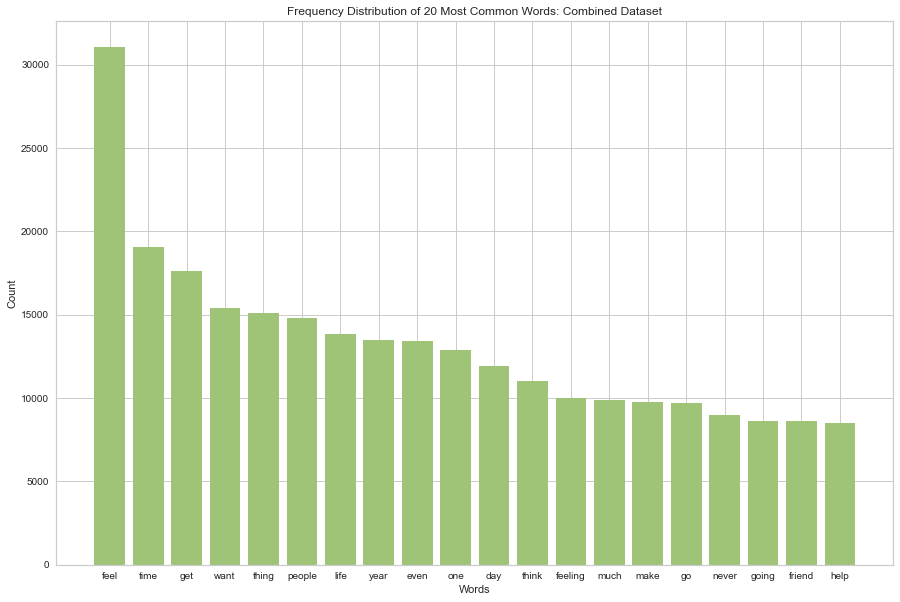

In [53]:
'''defining the corpus from cleaned text'''
corpus = []


'''creating exclusion list & updating corpus'''
for document in df['text']:
    exclude_list = ['anyone', 'else', 'like', "dont", 'know', "im", 'new', '[]', 'ive', 'really', 'would']
    document = list(str(document).split(' '))
    for word in document:
        if word not in exclude_list:
            corpus.append(word)

    
'''Frequency distribution'''
%matplotlib inline
fd = nltk.FreqDist(corpus)
freq_W = fd.most_common(20)

def Convert(tup, di):
    di = dict(tup)
    return di
      
di = {}
freq_dict = Convert(freq_W, di)

print(freq_dict)

fig = plt.figure(figsize=(15,10))
plt.title("Frequency Distribution of 20 Most Common Words: Combined Dataset")
plt.xlabel("Words")
plt.ylabel("Count")
plt.bar(freq_dict.keys(), freq_dict.values(), color='g')
plt.savefig("freq dist.png", dpi=300)
plt.show(fig)


In [99]:
'''printing a list of concordances for the word, "feel" '''
text = nltk.Text(corpus)
concordance_list = text.concordance_list("want", lines=20)
for entry in concordance_list:
    print(entry.line)
    
    
'''finding collocations for most common words'''
finder = nltk.collocations.QuadgramCollocationFinder.from_words(text)
finder_list = finder.ngram_fd.most_common(20)
for find in finder_list:
    print(find)

ks wither away writhe insignificance want haunt everyday turn question even ma
oid wanna end life create kind thing want go college make parent happy want ac
ng want go college make parent happy want acknowledge possibly struggling depr
ast year half career major care much want rest life teenage year complete wast
oying though friend relationship one want one doubt manage ever find someone w
t one doubt manage ever find someone want since emotionally unstable plan futu
nk made slip last night telling wife want go friend invited u made something e
mily friend supportive family friend want upset opening tried tell okay though
talk tell family daughter everything want kill constant pain fall asleep cry e
 scared upset scared disappoint time want die urge inside getting much powerfu
nk 4 day hey guy feeling discouraged want closer ex reply try keep faith bette
wed pride taken 5th year improve gpa want go college go community college firs
 hate also thrilled going get career want bad highsc

## POS tags, and their distribution

In [68]:
'''Building a dataframe with POS tagged tokens'''
text = []
for document in df['text']:
    document = list(str(document).split(' '))
    text.append(document)

    
    
pos_df = pd.DataFrame()

#Text classification: pos tagging
pos_tagged_text = []

for ele in text:
    pos_tagged_text.append(nltk.pos_tag(ele))

pos_df['pos_text'] = pos_tagged_text

pos_df['pos_text']

0        [(struggling, VBG), (sad, JJ), (really, RB), (...
1        [(something, NN), (broke, VBD), (inside, RB), ...
2        [(get, VB), (anything, NN), (done, VBN), (moti...
3        [(go, VB), (college, NN), (make, VBP), (parent...
4        [(maybe, RB), (genetics, NNS), (maybe, RB), (c...
                               ...                        
27146    [(seek, NN), (help, NN), (know, VB), (might, M...
27147    [(know, VB), (sound, JJ), (strange, JJ), (thin...
27148    [(good, JJ), (see, NN), (section, NN), (kind, ...
27149    [(maybe, RB), (start, VB), (need, MD), (defini...
27150    [(told, VBN), (dissociation, NN), (get, VB), (...
Name: pos_text, Length: 27151, dtype: object

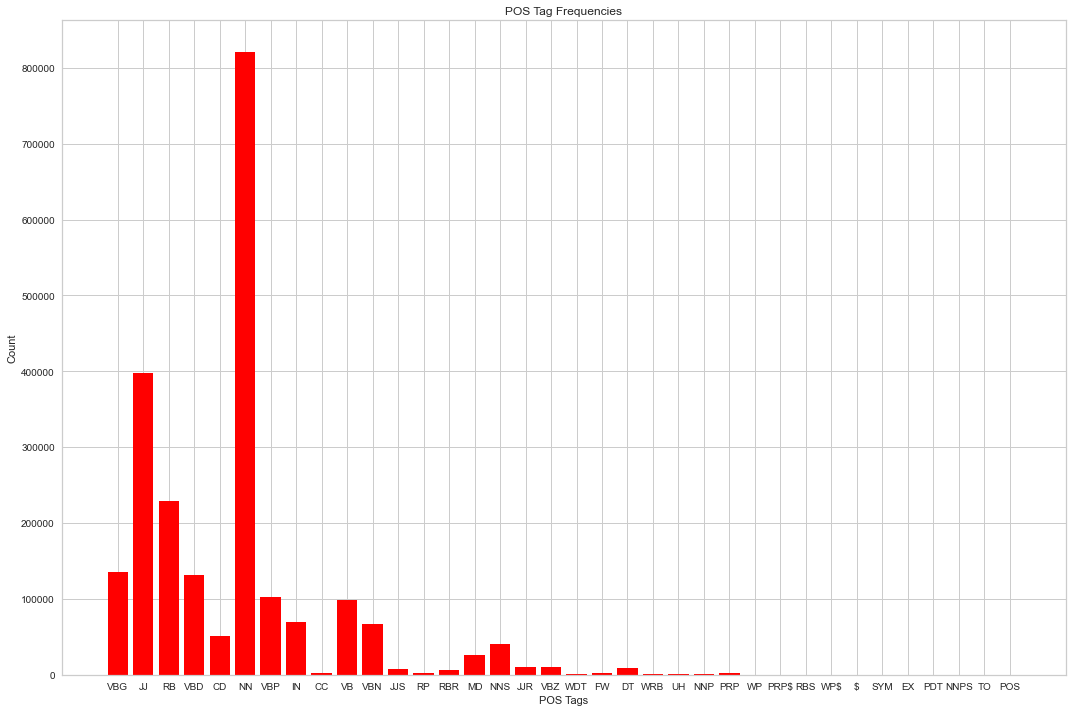

In [72]:
'''creating a dictionary to store counts of unique POS tags'''
pos_list = []
for row in pos_df['pos_text']:
    for tup in row:
        if tup[1] not in pos_list:
            pos_list.append(tup[1])
            
pos_dict = {}
for item in pos_list:
    pos_dict[item] = 0
    for row in pos_df['pos_text']:
        for tup in row:
            if tup[1] == item:
                pos_dict[item] += 1
                           

'''Plotting the counts'''
%matplotlib inline

fig = plt.figure(figsize=(15,10))
plt.bar(pos_dict.keys(), pos_dict.values(), color='red')
plt.title("POS Tag Frequencies")
plt.xlabel("POS Tags")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("pos_dist.png", dpi=300)
plt.show()

# Feature Exploration

Process:
- Vectorization
- Generate WordCloud for better visualization
- Obtain bar graph of the 50 most common features
- Dimensionality reduction for transforming sparse data & visualization of features
- Visualizing class distribution & balancing out samples in each class (2 methods are compared)
    - RandomOverSampling
    - RandomUnderSampling

## Vectorization

In [3]:
'''defining vectorizer'''
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.5, 
                             smooth_idf=True)


'''vectorizing text, and mapping the labels'''
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}

X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)


print(X.shape)
y.shape

(27151, 65595)


(27151,)

## WordCloud Generation

This WordCloud was a challenge due to the .get_feature_names() method returning duplicate words with an apostrophy at the end. I specified the redundancies to exclude by studying the WordCloud, and the results look much cleaner and more insightful than before. The result is also consistent with the frequency distribution I did on the corpus earlier.

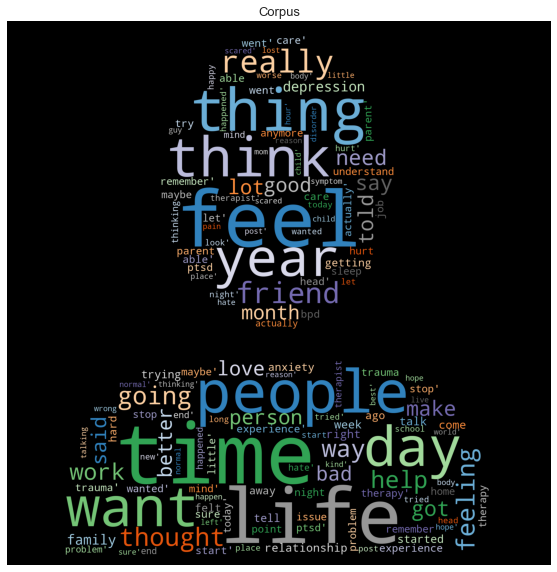

In [77]:
'''exclusion list of redundant features (predominantly duplicate words with an apostrophy)'''
exclude_list = ['anyone', 'else', "feel'", 'like',"like'", 
                "dont", "dont'", 'know', "im'","im", 'new', "time'", 
                "people'", "year'", "life'","ive'", "know'", "think'", 
                "day'", "thing'", "really'", "friend'", "want'", "said'",
                "make'", "thought'", "told'", "help'", "going'", "dindt'", 
                "felt'", "good'", "didnt'", "depression'", "way'", "got'", 
                "week'", "month'", "say'", "try'", "work'", "feeling'", "lot'",
                "relationship'", "talk'", "family'", "tell'", "anxiety'", "need'", "long'",
                "bad'", "love'", "self'", "away'", "better'", "right'", "doesnt'", "right'", "point'", "come'",
                "job'", "issue'", "getting'", "hard'", "mental'", "bipolar'", "started'", "person'",
                "home'", "wwanted'", "bpd'", "happy'", "leave'", "past'", "live'", 
                "trying'", "house'", "understand'", "anymore'", "feel abit", "sleep'"]


'''getting the names of features and storing them into a new list with the exclusion in place'''
features = vectorizer.get_feature_names()
features_list = []
for feature in features:
    if feature not in exclude_list:
        features_list.append(feature)

        
# Import image to np.array
mask = np.array(Image.open('user.png'))
        
'''defining method to generate a WordCloud'''
def generate_wordcloud(data, title):
    cloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=exclude_list,
                      collocations=False, 
                      mask=mask).generate_from_text(data)
    plt.figure(figsize=(14,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.savefig("wordcloud.png", dpi=300)
    plt.show()
    
generate_wordcloud(str(features_list), 'Corpus')

In [78]:
'''checking for null values'''
pd.isnull(df).sum() > 0

text      True
label    False
dtype: bool

## Visualizing Top 50 Features

Note that some features are bigrams, as specified in the vectorizer under the n_gram_range parameter.

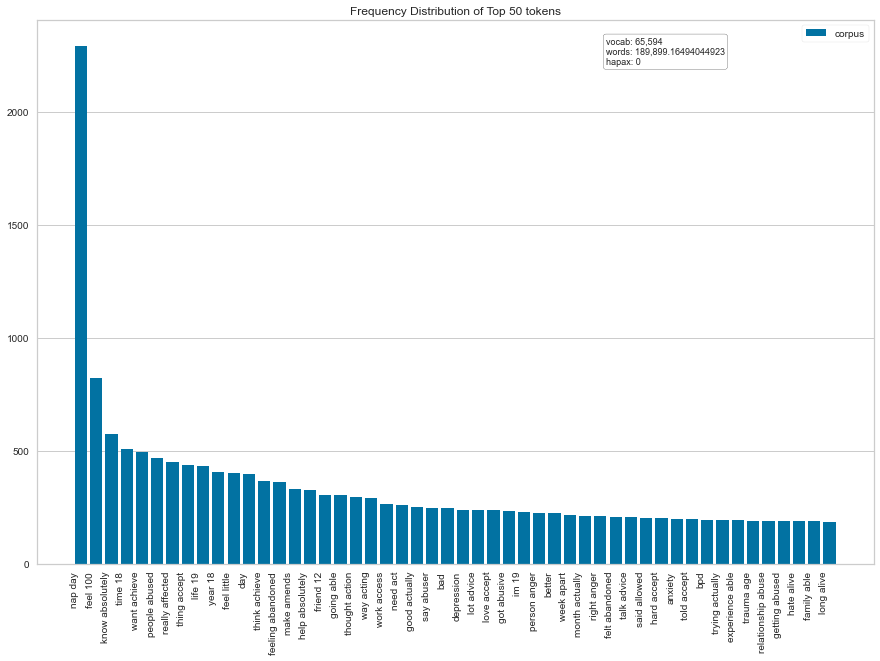

<Figure size 432x288 with 0 Axes>

In [79]:
'''Yellowbrick helps visualize features really easily!'''
visualizer = FreqDistVisualizer(features=features_list, orient='v', size=(1080,720))
visualizer.fit(X)
visualizer.show()
plt.tight_layout()
plt.savefig('top_50.png', dpi=500)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 42)


# PCA Dimensionality Reduction


<Figure size 576x432 with 0 Axes>

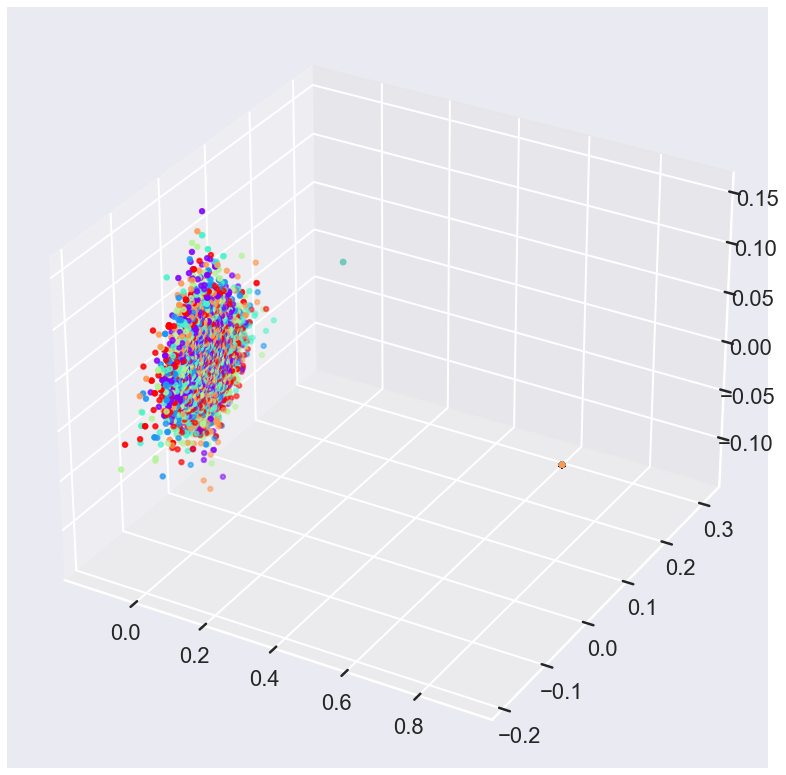

In [28]:
pca = PCA(n_components=100)

X_train = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,50], X_train[:,99], c=y_train, cmap='rainbow')
plt.savefig("PCA.png", dpi=300)
plt.show()

In [29]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

## Evaluation

Evaluation with PCA transformation

In [30]:
model_dict={
    'SGD': SGDClassifier(),
    'LOG': LogisticRegression(),
    'RF': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'DUM': DummyClassifier(),
}

X_test = pca.fit_transform(X_test)
    
for k, v in model_dict.items():
    model = v
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

       
    print(k)
    print(classification_report(y_test, y_pred))
        




SGD
              precision    recall  f1-score   support

           0       0.34      0.37      0.35      1559
           1       0.26      0.22      0.24      1119
           2       0.15      0.08      0.10      1251
           3       0.29      0.39      0.33      1576
           4       0.32      0.41      0.36      1478
           5       0.21      0.16      0.18      1163

    accuracy                           0.28      8146
   macro avg       0.26      0.27      0.26      8146
weighted avg       0.27      0.28      0.27      8146



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LOG
              precision    recall  f1-score   support

           0       0.34      0.35      0.35      1559
           1       0.29      0.28      0.29      1119
           2       0.19      0.16      0.17      1251
           3       0.30      0.31      0.31      1576
           4       0.33      0.39      0.36      1478
           5       0.20      0.17      0.18      1163

    accuracy                           0.29      8146
   macro avg       0.27      0.28      0.28      8146
weighted avg       0.28      0.29      0.28      8146

RF
              precision    recall  f1-score   support

           0       0.30      0.41      0.35      1559
           1       0.31      0.30      0.30      1119
           2       0.21      0.15      0.18      1251
           3       0.29      0.38      0.33      1576
           4       0.36      0.35      0.36      1478
           5       0.26      0.13      0.18      1163

    accuracy                           0.30      8146
   macro avg    

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Result

As expected, PCA is not great at handling sparse datasets. Reducing dimensions to 100 explained only 18% of the variance, and that is why the results aren't great here. Most likely would achieve better results with running the dataset through TruncatedSVD first.

# Dimensionality Reduction with UMAP

Note that this has been reduced down to 2-dimensions, and would likely achieve a more robust figure when expanded slightly. Let's take a closer look.

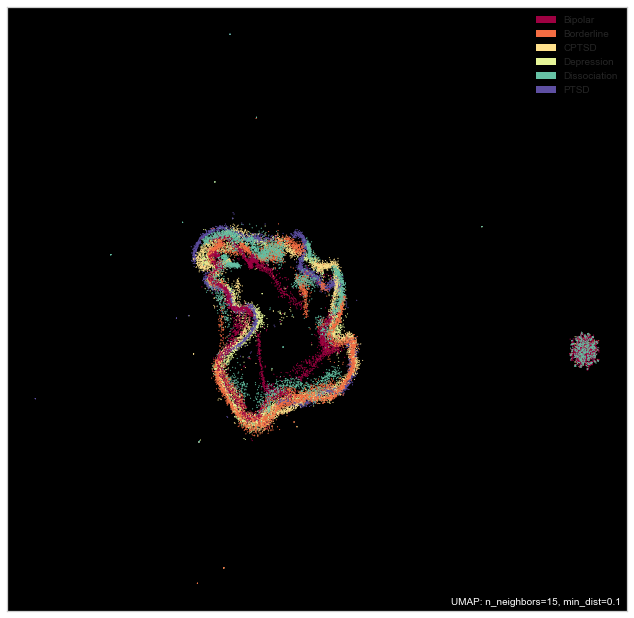

In [13]:
'''default for UMAP is 2-dimensions, at 15 neighborhoods and 0.1 min_dist.'''
mapper = umap.UMAP().fit(X)

%matplotlib inline
umap.plot.points(mapper, labels=y_label, theme='inferno')
plt.savefig('dimension_reduced.png', dpi=500)

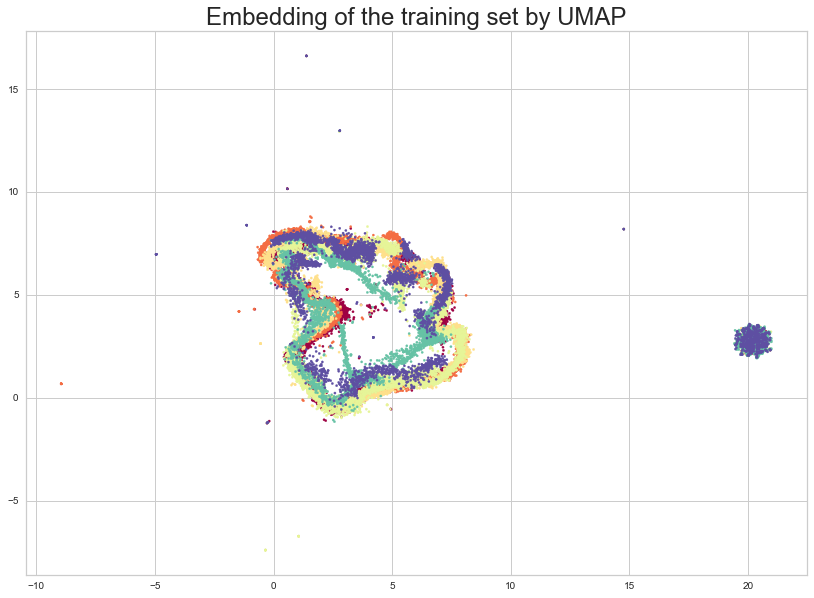

In [31]:
fig = plt.figure(figsize=(14,10))
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], s= 5, c=y, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);
plt.savefig("Embedding.png", dpi=500)

## Feature Exploration Tool with BokehJS 

By hovering over this plot below, Bokeh allows us to take a much more intimate look at the features. By mapping the appropriate labels we can easily visualize where in the matrix the classes are clustered. 

In [17]:
hover_data = pd.DataFrame({'index': np.arange(len(y)),
                           'label': y})
hover_data['item'] = hover_data.label.map({0:'depression',
                                           1:'ptsd',
                                           2:'cptsd',
                                           3:'bpd',
                                           4:'bipolar',
                                           5:'dissociation'})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=y, hover_data=hover_data, point_size=2)
umap.plot.show(p)

Loading BokehJS ...

In [25]:
data_umap = umap.UMAP().fit_transform(X)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    data_umap, 
    y, 
    test_size = .3, 
    shuffle = True,
    random_state=42
)

## Evaluation


In [26]:
model_dict={
    'SGD': SGDClassifier(),
    'LOG': LogisticRegression(),
    'RF': RandomForestClassifier(),
    'ADA': AdaBoostClassifier(),
    'GNB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'DUM': DummyClassifier(),
}


    
for k, v in model_dict.items():
    model = v
    model.fit(X_train_b, y_train_b)
    y_pred = model.predict(X_test_b)

       
    print(k)
    print(classification_report(y_test_b, y_pred))
        

        


SGD
              precision    recall  f1-score   support

           0       0.39      0.07      0.12      1559
           1       0.00      0.00      0.00      1119
           2       0.00      0.00      0.00      1251
           3       0.26      0.74      0.38      1576
           4       0.26      0.60      0.36      1478
           5       0.00      0.00      0.00      1163

    accuracy                           0.27      8146
   macro avg       0.15      0.23      0.14      8146
weighted avg       0.17      0.27      0.16      8146



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LOG
              precision    recall  f1-score   support

           0       0.34      0.40      0.37      1559
           1       0.00      0.00      0.00      1119
           2       0.15      0.13      0.14      1251
           3       0.25      0.45      0.32      1576
           4       0.30      0.49      0.37      1478
           5       0.40      0.00      0.00      1163

    accuracy                           0.27      8146
   macro avg       0.24      0.24      0.20      8146
weighted avg       0.25      0.27      0.22      8146



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1559
           1       0.56      0.55      0.56      1119
           2       0.47      0.45      0.46      1251
           3       0.54      0.55      0.55      1576
           4       0.59      0.65      0.62      1478
           5       0.54      0.47      0.50      1163

    accuracy                           0.55      8146
   macro avg       0.55      0.55      0.55      8146
weighted avg       0.55      0.55      0.55      8146

ADA
              precision    recall  f1-score   support

           0       0.26      0.13      0.17      1559
           1       0.28      0.22      0.24      1119
           2       0.29      0.21      0.24      1251
           3       0.26      0.37      0.31      1576
           4       0.33      0.43      0.37      1478
           5       0.25      0.31      0.28      1163

    accuracy                           0.28      8146
   macro avg    

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Feature Relationships (edge-bundling) Visualization

These adjacent relationships of embeddings show distinct branches with relatively clean bundling. This shows that the embedding achieves a decent spread over the matrix, and will likely yield good results. 

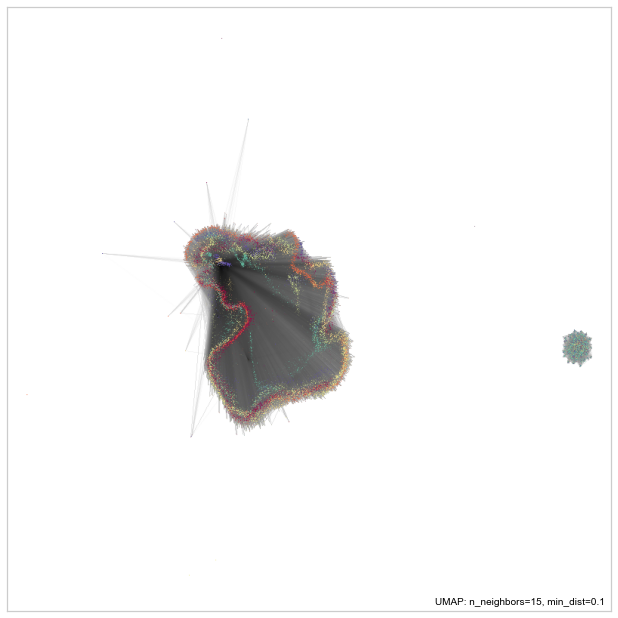

In [30]:
%matplotlib inline
umap.plot.connectivity(
    mapper, 
    cmap="rainbow",
    labels=y,
    show_points=True
)
plt.savefig('comorbidity.png', dpi=500)

## Class Distribution Visualization


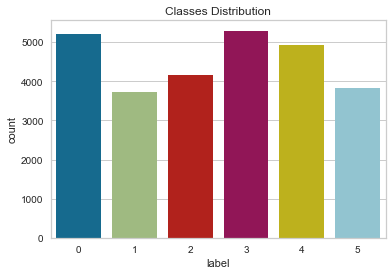

In [32]:
sns.countplot(x='label', data=df)
plt.title("Classes Distribution")
plt.savefig("Class.png", dpi=300)

## Balancing Out Class Distribution (2 methods)

In the next notebook, I compare the performances of two different methods of random sampling - starting with Random Over Sampler, then Random Under Sampler. 

In [33]:
print("original class counts: " + str(pd.value_counts(y.ravel())))

original class counts: 3    5290
0    5205
4    4936
2    4158
5    3832
1    3730
dtype: int64
